# <div align="center"> Implémentez un modèle de scoring </div>


# <div align="center"> Partie Prédiction </div>

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as st
from sklearn import neighbors
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, IsolationForest
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.metrics import accuracy_score,make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing
import itertools
from sklearn.decomposition import PCA
from joblib import dump, load
from sklearn import model_selection
from sklearn import neighbors, metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from datetime import date, time, datetime
import xgboost as xgb
import shap
from sklearn.dummy import DummyRegressor
import time
import gc
import folium
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import RocCurveDisplay
import mlflow
from mlflow.models import infer_signature
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, DataQualityPreset
from warnings import simplefilter 
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    

# I. Data Preparation

In [2]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)


@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('./Sources/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('./Sources/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('./Sources/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('./Sources/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('./Sources/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('./Sources/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('./Sources/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('./Sources/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg



In [10]:
debug = False
num_rows = 10000 if debug else None
df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()  

Train samples: 307511, test samples: 48744


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 18s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 21s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 11s
Installments payments df shape: (339587, 26)
Process installments payments - done in 28s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 16s


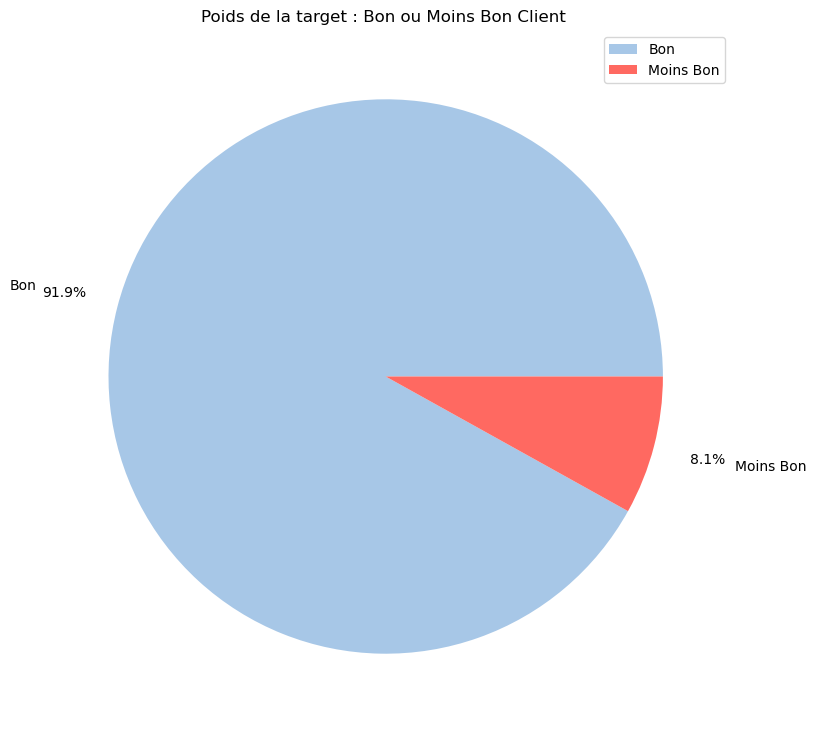

In [11]:
couleur_outlier=['#A7C7E7','#ff6961']

plt.figure(figsize = (9, 9))
sns.set_palette('pastel')
x =df['TARGET'].value_counts(normalize=True).sort_index()
plt.pie(x, labels = ['Bon','Moins Bon'],
           colors = couleur_outlier,
           autopct = lambda x: str(round(x, 1)) + '%',
           pctdistance = 1.2, labeldistance = 1.3,
          shadow = False)
plt.title("Poids de la target : Bon ou Moins Bon Client ")
plt.legend()

# II. Normalisation / Extraction des Features les plus importants

In [3]:
def normalisation_v0(df,liste_col):
    for col in liste_col: 
        X = df.loc[(df[col].replace(np.nan, 0)!=0),[col]]
        col_s=col+"_s"
        df.loc[((df[col]==0) | (df[col].replace(np.nan, 0)==0)),[col_s]]=0
        if len(X)>0:
            df.loc[(df[col].replace(np.nan, 0)!=0),[col_s]] = MinMaxScaler().fit_transform(X)    
    
def normalisation(df_v,liste_col,liste_col_norm):
    #df_v = df_v.reset_index()  
    varscaler = MinMaxScaler().fit_transform(df_v[liste_col])  
    df_v[liste_col_norm] = pd.DataFrame(varscaler,columns = liste_col)

#Fonction pour renvoyer le cout métier avec un coût FN est dix fois supérieur au coût d’un FP    
def cout_metier(y_true, y_pred, fp_cost, fn_cost, vp_cost, vn_cost):
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    fn = ((y_true == 1) & (y_pred == 0)).sum()
    vp = ((y_true == 1) & (y_pred == 1)).sum()
    vn = ((y_true == 0) & (y_pred == 0)).sum()
    cost = fp * fp_cost + fn * fn_cost + vp * vp_cost + vn * vn_cost
    return cost    

#Renvoyer le score métier pour optimiser le coût métier
def mon_score_metier(estimator,xtrain, ytrain):
    
    #Calcul y_proba impayé
    ypred_proba = estimator.predict_proba(xtrain)[:,1]
    
    # Optimisation du seuil avec la courbe ROC
    #fpr, tpr, thresholds = roc_curve(ytrain, ypred_proba)
    #J = tpr - fpr
    #ix = np.argmax(J)
    #best_thresh = thresholds[ix]
    
    # Optimisisation du seuil en fonction du coût métier le plus bas
    thresholds = np.arange(0, 1, 0.01)
    fp_cost = 1  # Coût des faux positifs
    fn_cost = 10  # Coût des faux négatifs
    vp_cost = 0  # Coût des vrais positifs
    vn_cost = 0  # Coût des vrais négatifs
    costs = []
    for threshold in thresholds:
        y_pred = (ypred_proba > threshold).astype(int)
        cost = cout_metier(ytrain, y_pred, fp_cost, fn_cost, vp_cost, vn_cost)
        costs.append(cost)
    
    best_thresh = thresholds[np.argmin(costs)]
    
    #calcul du y préduction en fonction de la proba et du seuil
    ypred = (ypred_proba > best_thresh).astype(int)
    
    #Matrice de de confusion pour optimiser le coût métier
    matrice = confusion_matrix(ytrain, ypred)
    # Nombre de True Negatifs
    tn = matrice[0, 0]
    # Nombre de Faux Négatifs
    fn = matrice[1, 0]
    # Nombre de Faux Positifs
    fp = matrice[0, 1]
    # Nombre de True Positifs
    tp = matrice[1, 1]
    
    score = 1-(fn*fn_cost+fp*fp_cost)/(tn+fn*fn_cost+fp*fp_cost+tp)
    return score    

#Accuracy via une prédiction optimisant le seuil optimal coût métier
def accuracy_optimise(estimator,xtrain, ytrain):
    
    #Calcul y_proba impayé
    ypred_proba = estimator.predict_proba(xtrain)[:,1]
    
    # Optimisisation du seuil en fonction du coût métier le plus bas
    thresholds = np.arange(0, 1, 0.01)
    fp_cost = 1  # Coût des faux positifs
    fn_cost = 10  # Coût des faux négatifs
    vp_cost = 0  # Coût des vrais positifs
    vn_cost = 0  # Coût des vrais négatifs
    costs = []
    for threshold in thresholds:
        y_pred = (ypred_proba > threshold).astype(int)
        cost = cout_metier(ytrain, y_pred, fp_cost, fn_cost, vp_cost, vn_cost)
        costs.append(cost)
    
    best_thresh = thresholds[np.argmin(costs)]
    
    #calcul du y préduction en fonction de la proba et du seuil
    ypred = (ypred_proba > best_thresh).astype(int)
    
    #Matrice de de confusion pour optimiser le coût métier
    matrice = confusion_matrix(ytrain, ypred)
    # Nombre de True Negatifs
    tn = matrice[0, 0]
    # Nombre de Faux Négatifs
    fn = matrice[1, 0]
    # Nombre de Faux Positifs
    fp = matrice[0, 1]
    # Nombre de True Positifs
    tp = matrice[1, 1]
    
    score = (tn+tp)/(tn+fn+fp+tp)
    return score  

def seuil_optimise(estimator,xtrain, ytrain):
    
    #Calcul y_proba impayé
    ypred_proba = estimator.predict_proba(xtrain)[:,1]
    
    # Optimisisation du seuil en fonction du coût métier le plus bas
    thresholds = np.arange(0, 1, 0.01)
    fp_cost = 1  # Coût des faux positifs
    fn_cost = 10  # Coût des faux négatifs
    vp_cost = 0  # Coût des vrais positifs
    vn_cost = 0  # Coût des vrais négatifs
    costs = []
    for threshold in thresholds:
        y_pred = (ypred_proba > threshold).astype(int)
        cost = cout_metier(ytrain, y_pred, fp_cost, fn_cost, vp_cost, vn_cost)
        costs.append(cost)
    
    best_thresh = thresholds[np.argmin(costs)]
    return best_thresh  

def preparation_features(df):
    new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in df.columns}
    new_n_list = list(new_names.values())
    #Normalisation des features
    new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
    df = df.rename(columns=new_names)
    feats = [f for f in df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feats_norm = [f"{s}_s" for s in feats]
    #transfo_Nan(df,feats)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df[feats] = df[feats].fillna(0)
    df = df.reset_index()  
    normalisation(df,feats,feats_norm)
    df.drop(columns=feats, inplace=True)
    return df,feats_norm

#Extraction des Features importantes à partir des 10 000 lignes
def extract_feature_importance_random_forest(df,nb_features):

    df, feats_norm = preparation_features(df)
    train_df = df[df['TARGET'].notnull()][:10000]
    test_df = df[df['TARGET'].isnull()][:10000]
    print("Starting Random Forest //to extract features// Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    #del df
    gc.collect()
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    #feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    data = df[feats_norm] 
    xtrain = train_df[feats_norm] 
    ytrain = train_df['TARGET']
    
    
    # Number of trees in random forest
    n_estimators = [1000]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [10]
    # Minimum number of samples required to split a node
    min_samples_split = [5],#[2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [2],#[1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    
    param_grid = {'n_estimators': n_estimators,
                   #'max_features': max_features,
                   'max_depth': max_depth}
                  # 'min_samples_split': min_samples_split,
                  # 'min_samples_leaf': min_samples_leaf,
                  # 'bootstrap': bootstrap}
                       
                
    # Choisir un score à optimiser, ici le
    scoring = {"Score_Metier":mon_score_metier,"AUC": "roc_auc", "Accuracy":accuracy_optimise}
    
    # Créer un Random Forest Regressor avec recherche d'hyperparamètre par validation croisée
    clf = model_selection.GridSearchCV(
        RandomForestClassifier(), # Gradiant
        param_grid,     # hyperparamètres à tester
        cv=5,           # nombre de folds de validation croisée
        scoring=scoring,   # score à optimiser : score métier et scores à monitorer : accuracy/roc_auc 
        refit="Score_Metier",
        return_train_score=False
    )

    # Optimiser ce modèle sur le jeu d'entraînement
    clf.fit(xtrain, ytrain)

    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(clf.best_params_)


    print("Meilleur score métier sur le jeu d'entraînement:")
    print(clf.best_score_)

    print("Meilleur roc auc sur le jeu d'entraînement:")
    print(clf.cv_results_['mean_test_AUC'][clf.best_index_])
    
    print("Meilleur accuracy sur le jeu d'entraînement:")
    print(clf.cv_results_['mean_test_Accuracy'][clf.best_index_])
    
   
                   
    # Afficher les performances correspondantes
    print("Résultats de la validation croisée :")
    for mean_Score_Metier, std_Score_Metier,mean_roc_auc, std_roc_auc,mean_Accuracy, std_Accuracy, params in zip(
            clf.cv_results_['mean_test_Score_Metier'], # score métier moyen
            clf.cv_results_['std_test_Score_Metier'],  # écart-type du score métier
            clf.cv_results_['mean_test_AUC'], # roc auc moyen
            clf.cv_results_['std_test_AUC'],  # écart-type du roc auc
            clf.cv_results_['mean_test_Accuracy'], # Accuracy moyen
            clf.cv_results_['std_test_Accuracy'],  # écart-type Accuracy
            clf.cv_results_['params']           # valeur de l'hyperparamètre
        ):

        print("{} = {:.3f} (+/-{:.03f}) {} = {:.3f} (+/-{:.03f}) {} = {:.3f} (+/-{:.03f}) for {}".format(
            "score métier",
            mean_Score_Metier,
            std_Score_Metier*2,
             "roc auc",
            mean_roc_auc,
            std_roc_auc*2,
            "accuracy",
            mean_Accuracy,
            std_Accuracy*2,
            params
        ) )
    
    xtest = test_df[feats_norm]
                       
    #y_pred = clf.predict_proba(xtest)
    y_pred = clf.predict_proba(xtest)[:,1]                   
    feature_importance_df = pd.DataFrame()
    feature_importance_df["feature"] = clf.best_estimator_.feature_names_in_
    feature_importance_df["importance"] = clf.best_estimator_.feature_importances_
    cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:nb_features].index
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]["feature"]
    return df, best_features


# III. Prediction avec Cross Validation selon score métier

In [4]:
def dummy_classifier(df,debug = False,train_smote = False):
    #Set our tracking server uri for logging
    mlflow.set_tracking_uri("http://localhost:5000")
    
    df, feats = extract_feature_importance_random_forest(df,30)
    
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting Dummy Classifier Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    
    gc.collect()
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])

    data = df[feats] 
    xtrain = train_df[feats] 
    ytrain = train_df['TARGET']
    
    # Hyper-Paramètres pour la régression logistique

                
    # Choisir un score à optimiser, ici le
    scoring = {"Score_Metier":mon_score_metier,"AUC": "roc_auc", "Accuracy":accuracy_optimise,"Seuil":seuil_optimise}
    
    param_grid = {'strategy': ['prior'] }
         # Créer un Random Forest Regressor avec recherche d'hyperparamètre par validation croisée
    clf = model_selection.GridSearchCV(
            DummyClassifier(), 
            param_grid,     # hyperparamètres à tester
            cv=5,           # nombre de folds de validation croisée
            scoring=scoring,   # score à optimiser : score métier et scores à monitorer : accuracy/roc_auc 
            refit="Score_Metier",
            return_train_score=False
        )       
        
    # Optimiser ce modèle sur le jeu d'entraînement
    start = time.time()
    clf.fit(xtrain, ytrain)
    tps_exec=(time.time() - start)

    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(clf.best_params_)


    print("Meilleur score métier sur le jeu d'entraînement:")
    print(clf.best_score_)

    print("Meilleur roc auc sur le jeu d'entraînement:")
    print(clf.cv_results_['mean_test_AUC'][clf.best_index_])
    
    print("Meilleur accuracy sur le jeu d'entraînement:")
    print(clf.cv_results_['mean_test_Accuracy'][clf.best_index_])
    
    #Tracking MLFLOW
    
    mlflow.set_experiment("Tracking Model Home Credit")
    
    with mlflow.start_run():
        # Log the hyperparameters
        mlflow.log_params(clf.best_params_)
    
        # Log du score métier 
        mlflow.log_metric("score métier", clf.best_score_)
        mlflow.log_metric("roc_auc", clf.cv_results_['mean_test_AUC'][clf.best_index_])
        mlflow.log_metric("accuracy", clf.cv_results_['mean_test_Accuracy'][clf.best_index_])
        mlflow.log_metric("seuil", clf.cv_results_['mean_test_Seuil'][clf.best_index_]) 
        mlflow.log_metric("temps entraînement en sec",tps_exec)
        
        mlflow.set_tag("Training Info", "Model Dummy Classifier avec Cross Validation sans rééquilibrage SMOT") 
                
        # Infer the model signature
        signature = infer_signature(xtrain, clf.predict_proba(xtrain))
    
        # Log the model
        model_info = mlflow.sklearn.log_model(
            sk_model=clf,
            artifact_path="HOME_CREDIT",
            signature=signature,
            input_example=xtrain,
            registered_model_name="tracking-dummy-classifier",
        )               
                   
                   
        # Afficher les performances correspondantes
        print("Résultats de la validation croisée :")
        for mean_Score_Metier,std_Score_Metier,mean_roc_auc, std_roc_auc,mean_Accuracy,std_Accuracy,mean_Seuil,std_Seuil,params in zip(
                clf.cv_results_['mean_test_Score_Metier'], # score métier moyen
                clf.cv_results_['std_test_Score_Metier'],  # écart-type du score métier
                clf.cv_results_['mean_test_AUC'], # roc auc moyen
                clf.cv_results_['std_test_AUC'],  # écart-type du roc auc
                clf.cv_results_['mean_test_Accuracy'], # Accuracy moyen
                clf.cv_results_['std_test_Accuracy'],  # écart-type Accuracy
                clf.cv_results_['mean_test_Seuil'], # Seuil moyen
                clf.cv_results_['std_test_Seuil'],  # écart-type Seuil
                clf.cv_results_['params']           # valeur de l'hyperparamètre
            ):

            print("{} = {:.3f} (+/-{:.03f}) {} = {:.3f} (+/-{:.03f}) {} = {:.3f} (+/-{:.03f}) {} = {:.3f} (+/-{:.03f}) for {}".format(
                "score métier",
                mean_Score_Metier,
                std_Score_Metier*2,
                 "roc auc",
                mean_roc_auc,
                std_roc_auc*2,
                "accuracy",
                mean_Accuracy,
                std_Accuracy*2,
                "seuil",
                mean_Seuil,
                std_Seuil*2,
                params
            ) )

        #loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)
        loaded_model = mlflow.sklearn.load_model(model_info.model_uri)

        xtest = test_df[feats]

        start = time.time()
        y_pred = loaded_model.predict_proba(xtest)[:,1]                   
        tps_exec=(time.time() - start)
        mlflow.log_metric("temps inférence en sec",tps_exec)
        
        if not debug:
            test_df['TARGET'] = y_pred
            test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_file_name.csv', index= False)

        # Courbe ROC
        #fig, ax = plt.subplots(figsize=(6, 6))
        display = RocCurveDisplay.from_estimator(clf, xtrain, ytrain)
        _ = display.ax_.set(xlabel='False Positive Rate',ylabel='True Positive Rate',title='Courbe ROC',)
        plt.savefig('Courbe-ROC.png',dpi=150)
        mlflow.log_artifact("Courbe-ROC.png")
        plt.show()
                                                       

def reg_log(df,debug = False,train_smote = False):
    #Set our tracking server uri for logging
    mlflow.set_tracking_uri("http://localhost:5000")
    
    df, feats = extract_feature_importance_random_forest(df,30)
    
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting Regression Logistic Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    
    gc.collect()
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])

    data = df[feats] 
    xtrain = train_df[feats] 
    ytrain = train_df['TARGET']
    
    # Hyper-Paramètres pour la régression logistique

    # Paramètres pour le SMOTE
    k_neighbors = [3,5]
    sampling_strategy = [0.2,0.35,0.5]
    C = [0.1, 1, 10, 100]
    penalty = ['l1','l2']
    solver = ['saga']
                    
                
    # Choisir un score à optimiser, ici le
    scoring = {"Score_Metier":mon_score_metier,"AUC": "roc_auc", "Accuracy":accuracy_optimise,"Seuil":seuil_optimise}
    
    if train_smote:
        #Lancement du modèle avec un pipeline faisant un rééquilibrage du jeu d'entrainement
        Smote_RL = Pipeline([('sampling', SMOTE()),('classification', LogisticRegression())])
         
        #La grille de paramétrage est enrichie avec les paramètres SMOTE    
        param_grid = {'sampling__k_neighbors': k_neighbors,
                      'sampling__sampling_strategy': sampling_strategy,
                      'classification__solver': solver,
                      'classification__C': C,
                      'classification__penalty': penalty}
    
        # Créer un Random Forest Regressor avec recherche d'hyperparamètre par validation croisée
        clf = model_selection.GridSearchCV(
            Smote_RL, 
            param_grid,     # hyperparamètres à tester
            cv=5,           # nombre de folds de validation croisée
            scoring=scoring,   # score à optimiser : score métier et scores à monitorer : accuracy/roc_auc 
            refit="Score_Metier",
            return_train_score=False
        )
    else:
        
        param_grid = {'solver': solver,
                      'C': C,
                      'penalty': penalty}
         # Créer un Random Forest Regressor avec recherche d'hyperparamètre par validation croisée
        clf = model_selection.GridSearchCV(
            LogisticRegression(), 
            param_grid,     # hyperparamètres à tester
            cv=5,           # nombre de folds de validation croisée
            scoring=scoring,   # score à optimiser : score métier et scores à monitorer : accuracy/roc_auc 
            refit="Score_Metier",
            return_train_score=False
        )       
        
    # Optimiser ce modèle sur le jeu d'entraînement
    start = time.time()
    clf.fit(xtrain, ytrain)
    tps_exec=(time.time() - start)

    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(clf.best_params_)


    print("Meilleur score métier sur le jeu d'entraînement:")
    print(clf.best_score_)

    print("Meilleur roc auc sur le jeu d'entraînement:")
    print(clf.cv_results_['mean_test_AUC'][clf.best_index_])
    
    print("Meilleur accuracy sur le jeu d'entraînement:")
    print(clf.cv_results_['mean_test_Accuracy'][clf.best_index_])
    
    print("Seuil Retenu sur le jeu d'entraînement:")
    print(clf.cv_results_['mean_test_Seuil'][clf.best_index_])
    
    #Tracking MLFLOW
    
    mlflow.set_experiment("Tracking Model Home Credit")
    
    with mlflow.start_run():
        # Log the hyperparameters
        mlflow.log_params(clf.best_params_)
    
        # Log du score métier 
        mlflow.log_metric("score métier", clf.best_score_)
        mlflow.log_metric("roc_auc", clf.cv_results_['mean_test_AUC'][clf.best_index_])
        mlflow.log_metric("accuracy", clf.cv_results_['mean_test_Accuracy'][clf.best_index_])
        mlflow.log_metric("seuil", clf.cv_results_['mean_test_Seuil'][clf.best_index_]) 
        mlflow.log_metric("temps entraînement en sec",tps_exec)
        if train_smote:
        # Set a tag that we can use to remind ourselves what this run was for
            mlflow.set_tag("Training Info", "Model Régression Logistique avec Cross Validation avec rééquilibrage SMOT")
        else:
             mlflow.set_tag("Training Info", "Model Régression Logistique avec Cross Validation sans rééquilibrage SMOT") 
                
        # Infer the model signature
        signature = infer_signature(xtrain, clf.predict_proba(xtrain))
    
        # Log the model
        model_info = mlflow.sklearn.log_model(
            sk_model=clf,
            artifact_path="HOME_CREDIT",
            signature=signature,
            input_example=xtrain,
            registered_model_name="tracking-regression-logistic",
        )               
                   
                   
        # Afficher les performances correspondantes
        print("Résultats de la validation croisée :")
        for mean_Score_Metier,std_Score_Metier,mean_roc_auc, std_roc_auc,mean_Accuracy,std_Accuracy,mean_Seuil,std_Seuil,params in zip(
                clf.cv_results_['mean_test_Score_Metier'], # score métier moyen
                clf.cv_results_['std_test_Score_Metier'],  # écart-type du score métier
                clf.cv_results_['mean_test_AUC'], # roc auc moyen
                clf.cv_results_['std_test_AUC'],  # écart-type du roc auc
                clf.cv_results_['mean_test_Accuracy'], # Accuracy moyen
                clf.cv_results_['std_test_Accuracy'],  # écart-type Accuracy
                clf.cv_results_['mean_test_Seuil'], # Seuil moyen
                clf.cv_results_['std_test_Seuil'],  # écart-type Seuil
                clf.cv_results_['params']           # valeur de l'hyperparamètre
            ):

            print("{} = {:.3f} (+/-{:.03f}) {} = {:.3f} (+/-{:.03f}) {} = {:.3f} (+/-{:.03f}) {} = {:.3f} (+/-{:.03f}) for {}".format(
                "score métier",
                mean_Score_Metier,
                std_Score_Metier*2,
                 "roc auc",
                mean_roc_auc,
                std_roc_auc*2,
                "accuracy",
                mean_Accuracy,
                std_Accuracy*2,
                "seuil",
                mean_Seuil,
                std_Seuil*2,
                params
            ) )

        #loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)
        loaded_model = mlflow.sklearn.load_model(model_info.model_uri)

        xtest = test_df[feats]

        start = time.time()
        y_pred = loaded_model.predict_proba(xtest)[:,1]                   
        tps_exec=(time.time() - start)
        mlflow.log_metric("temps inférence en sec",tps_exec)
        if not debug:
            test_df['TARGET'] = y_pred
            test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_file_name.csv', index= False)

        # Courbe ROC
        #fig, ax = plt.subplots(figsize=(6, 6))
        display = RocCurveDisplay.from_estimator(clf, xtrain, ytrain)
        _ = display.ax_.set(xlabel='False Positive Rate',ylabel='True Positive Rate',title='Courbe ROC',)
        plt.savefig('Courbe-ROC.png',dpi=150)
        mlflow.log_artifact("Courbe-ROC.png")
        plt.show()
                                                       
        if not train_smote:         
            coefficients = clf.best_estimator_.coef_[0]
            feature_importance = pd.DataFrame({'Feature': xtrain.columns, 'Importance': np.abs(coefficients)})
            feature_importance = feature_importance.sort_values('Importance', ascending=True)
            feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

def random_forest(df,debug = False,train_smote = False):
    #Set our tracking server uri for logging
    mlflow.set_tracking_uri("http://localhost:5000")
    
    df, feats = extract_feature_importance_random_forest(df,30)
    
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting Random Forest Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    
    gc.collect()
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])

    data = df[feats] 
    xtrain = train_df[feats] 
    ytrain = train_df['TARGET']
    
    # Hyper-Paramètres pour le RandomForest
    # Number of trees in random forest
    n_estimators = [100,300]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [10]
    # Minimum number of samples required to split a node
    min_samples_split = [5],#[2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [2],#[1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Paramètres pour le SMOTE
    k_neighbors = [3,5]
    sampling_strategy = [0.2,0.35,0.5]
    
                    
                
    # Choisir un score à optimiser, ici le
    scoring = {"Score_Metier":mon_score_metier,"AUC": "roc_auc", "Accuracy":accuracy_optimise,"Seuil":seuil_optimise}
    
    if train_smote:
        #Lancement du modèle avec un pipeline faisant un rééquilibrage du jeu d'entrainement
        Smote_RF = Pipeline([('sampling', SMOTE()),('classification', RandomForestClassifier())])
         
        #La grille de paramétrage est enrichie avec les paramètres SMOTE    
        param_grid = {'sampling__k_neighbors': k_neighbors,
                      'sampling__sampling_strategy': sampling_strategy,
                    'classification__n_estimators': n_estimators,
                    'classification__max_depth': max_depth}
    
        # Créer un Random Forest Regressor avec recherche d'hyperparamètre par validation croisée
        clf = model_selection.GridSearchCV(
            Smote_RF, 
            param_grid,     # hyperparamètres à tester
            cv=5,           # nombre de folds de validation croisée
            scoring=scoring,   # score à optimiser : score métier et scores à monitorer : accuracy/roc_auc 
            refit="Score_Metier",
            return_train_score=False
        )
    else:
        
        param_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth}
         # Créer un Random Forest Regressor avec recherche d'hyperparamètre par validation croisée
        clf = model_selection.GridSearchCV(
            RandomForestClassifier(), 
            param_grid,     # hyperparamètres à tester
            cv=5,           # nombre de folds de validation croisée
            scoring=scoring,   # score à optimiser : score métier et scores à monitorer : accuracy/roc_auc 
            refit="Score_Metier",
            return_train_score=False
        )       
        
    # Optimiser ce modèle sur le jeu d'entraînement
    start = time.time()
    clf.fit(xtrain, ytrain)
    tps_exec=(time.time() - start)

    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(clf.best_params_)


    print("Meilleur score métier sur le jeu d'entraînement:")
    print(clf.best_score_)

    print("Meilleur roc auc sur le jeu d'entraînement:")
    print(clf.cv_results_['mean_test_AUC'][clf.best_index_])
    
    print("Meilleur accuracy sur le jeu d'entraînement:")
    print(clf.cv_results_['mean_test_Accuracy'][clf.best_index_])
    
    print("Seuil Retenu sur le jeu d'entraînement:")
    print(clf.cv_results_['mean_test_Seuil'][clf.best_index_])
    
    #Tracking MLFLOW
    
    mlflow.set_experiment("Tracking Model Home Credit")
    
    with mlflow.start_run():
        # Log the hyperparameters
        mlflow.log_params(clf.best_params_)
    
        # Log du score métier 
        mlflow.log_metric("score métier", clf.best_score_)
        mlflow.log_metric("roc_auc", clf.cv_results_['mean_test_AUC'][clf.best_index_])
        mlflow.log_metric("accuracy", clf.cv_results_['mean_test_Accuracy'][clf.best_index_])
        mlflow.log_metric("seuil", clf.cv_results_['mean_test_Seuil'][clf.best_index_]) 
        mlflow.log_metric("temps entraînement en sec",tps_exec)
        if train_smote:
        # Set a tag that we can use to remind ourselves what this run was for
            mlflow.set_tag("Training Info", "Model Random Forest avec Cross Validation avec rééquilibrage SMOT")
        else:
            mlflow.set_tag("Training Info", "Model Random Forest avec Cross Validation sans rééquilibrage SMOT") 
                
        # Infer the model signature
        signature = infer_signature(xtrain, clf.predict_proba(xtrain))
    
        # Log the model
        model_info = mlflow.sklearn.log_model(
            sk_model=clf,
            artifact_path="HOME_CREDIT",
            signature=signature,
            input_example=xtrain,
            registered_model_name="tracking-random-forest",
        )               
                   
                   
        # Afficher les performances correspondantes
        print("Résultats de la validation croisée :")
        for mean_Score_Metier,std_Score_Metier,mean_roc_auc, std_roc_auc,mean_Accuracy,std_Accuracy,mean_Seuil,std_Seuil,params in zip(
                clf.cv_results_['mean_test_Score_Metier'], # score métier moyen
                clf.cv_results_['std_test_Score_Metier'],  # écart-type du score métier
                clf.cv_results_['mean_test_AUC'], # roc auc moyen
                clf.cv_results_['std_test_AUC'],  # écart-type du roc auc
                clf.cv_results_['mean_test_Accuracy'], # Accuracy moyen
                clf.cv_results_['std_test_Accuracy'],  # écart-type Accuracy
                clf.cv_results_['mean_test_Seuil'], # Seuil moyen
                clf.cv_results_['std_test_Seuil'],  # écart-type Seuil
                clf.cv_results_['params']           # valeur de l'hyperparamètre
            ):

            print("{} = {:.3f} (+/-{:.03f}) {} = {:.3f} (+/-{:.03f}) {} = {:.3f} (+/-{:.03f}) {} = {:.3f} (+/-{:.03f}) for {}".format(
                "score métier",
                mean_Score_Metier,
                std_Score_Metier*2,
                 "roc auc",
                mean_roc_auc,
                std_roc_auc*2,
                "accuracy",
                mean_Accuracy,
                std_Accuracy*2,
                "seuil",
                mean_Seuil,
                std_Seuil*2,
                params
            ) )

        #loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)
        loaded_model = mlflow.sklearn.load_model(model_info.model_uri)

        xtest = test_df[feats]

        start = time.time()
        y_pred = loaded_model.predict_proba(xtest)[:,1]                   
        tps_exec=(time.time() - start)
        mlflow.log_metric("temps inférence en sec",tps_exec)
        if not debug:
            test_df['TARGET'] = y_pred
            test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_file_name.csv', index= False)

        # Courbe ROC
        #fig, ax = plt.subplots(figsize=(6, 6))
        display = RocCurveDisplay.from_estimator(clf, xtrain, ytrain)
        _ = display.ax_.set(xlabel='False Positive Rate',ylabel='True Positive Rate',title='Courbe ROC',)
        plt.savefig('Courbe-ROC.png',dpi=150)
        mlflow.log_artifact("Courbe-ROC.png")
        plt.show()

        if not train_smote: 
            #Plot Features
            model = clf.best_estimator_
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(xtest)

            shap.summary_plot(shap_values, xtest, plot_type="bar")

            shap_values = explainer(xtest) 
            shap.plots.beeswarm(shap_values[:,:,1], max_display=25)


def XGBoost(df,debug = False,train_smote = False):
    #Set our tracking server uri for logging
    mlflow.set_tracking_uri("http://localhost:5000")
    
    df, feats = extract_feature_importance_random_forest(df,30)

    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting XGBoost Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    gc.collect()
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])

    data = df[feats] 
    xtrain = train_df[feats] 
    ytrain = train_df['TARGET']
                       
                
    # Choisir un score à optimiser, ici le
    scoring = {"Score_Metier":mon_score_metier,"AUC": "roc_auc", "Accuracy":accuracy_optimise,"Seuil":seuil_optimise}
    
    if train_smote:    
        
        # Paramètres pour le SMOTE    
        k_neighbors = [3,5]
        sampling_strategy = [0.2,0.35,0.5]
    
        #Lancement du modèle avec un pipeline faisant un rééquilibrage du jeu d'entrainement
        Smote_XGB = Pipeline([('sampling', SMOTE()),('classification', xgb.XGBClassifier())])
        # {'colsample_bytree': 0.6, 'gamma': 1.5, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 
                             #'n_estimators': 500, 'nthread': 20, 'subsample': 0.6}
                             
        #La grille de paramétrage est enrichie avec les paramètres SMOTE    
        param_grid = {'sampling__k_neighbors': k_neighbors,
                      'sampling__sampling_strategy': sampling_strategy,
                      'classification__nthread':[20],
                      'classification__gamma': [1.5],
                      'classification__subsample': [0.6],
                      'classification__max_depth': [7],
                      'classification__learning_rate': [0.05,0.1],
                      'classification__n_estimators': [100,300]}
    
        # Créer un Random Forest Regressor avec recherche d'hyperparamètre par validation croisée
        clf = model_selection.GridSearchCV(
            Smote_XGB, 
            param_grid,     # hyperparamètres à tester
            cv=5,           # nombre de folds de validation croisée
            scoring=scoring,   # score à optimiser : score métier et scores à monitorer : accuracy/roc_auc 
            refit="Score_Metier",
            return_train_score=False
        )        
    else: 
                             
        param_grid = {'nthread':[20],
                    'gamma': [1.5],
                    'subsample': [0.6],
                    'max_depth': [7],
                    'learning_rate': [0.05,0.1],
                    'n_estimators': [100,300]}

        # Créer un XGBoost Classifier avec recherche d'hyperparamètre par validation croisée
        clf = model_selection.GridSearchCV(
            xgb.XGBClassifier(), # Gradiant
            param_grid,     # hyperparamètres à tester
            cv=5,           # nombre de folds de validation croisée
            scoring=scoring,   # score à optimiser : score métier et scores à monitorer : accuracy/roc_auc 
            refit="Score_Metier",
            return_train_score=False
        )

    # Optimiser ce modèle sur le jeu d'entraînement
    start = time.time()
    clf.fit(xtrain, ytrain)
    tps_exec=(time.time() - start)

    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(clf.best_params_)


    print("Meilleur score métier sur le jeu d'entraînement:")
    print(clf.best_score_)

    print("Meilleur roc auc sur le jeu d'entraînement:")
    print(clf.cv_results_['mean_test_AUC'][clf.best_index_])
    
    print("Meilleur accuracy sur le jeu d'entraînement:")
    print(clf.cv_results_['mean_test_Accuracy'][clf.best_index_])
    
    print("Seuil Retenu sur le jeu d'entraînement:")
    print(clf.cv_results_['mean_test_Seuil'][clf.best_index_])
    
    #Tracking MLFLOW
    
    mlflow.set_experiment("Tracking Model Home Credit")
    
    with mlflow.start_run():
        # Log the hyperparameters
        mlflow.log_params(clf.best_params_)
    
        # Log du score métier 
        mlflow.log_metric("score métier", clf.best_score_)
        mlflow.log_metric("roc_auc", clf.cv_results_['mean_test_AUC'][clf.best_index_])
        mlflow.log_metric("accuracy", clf.cv_results_['mean_test_Accuracy'][clf.best_index_])
        mlflow.log_metric("seuil", clf.cv_results_['mean_test_Seuil'][clf.best_index_]) 
        mlflow.log_metric("temps entraînement en sec",tps_exec)                     

        # Set a tag that we can use to remind ourselves what this run was for
        if train_smote:
        # Set a tag that we can use to remind ourselves what this run was for
            mlflow.set_tag("Training Info", "Model XGBoost avec Cross Validation avec rééquilibrage SMOT")
        else:
            mlflow.set_tag("Training Info", "Model XGBoost avec Cross Validation sans rééquilibrage SMOT") 

        # Infer the model signature
        signature = infer_signature(xtrain, clf.predict_proba(xtrain))
    
        # Log the model
        model_info = mlflow.sklearn.log_model(
            sk_model=clf,
            artifact_path="HOME_CREDIT",
            signature=signature,
            input_example=xtrain,
            registered_model_name="tracking-xgboost",
        )               
                   
                   
        # Afficher les performances correspondantes
        print("Résultats de la validation croisée :")
        for mean_Score_Metier,std_Score_Metier,mean_roc_auc, std_roc_auc,mean_Accuracy,std_Accuracy,mean_Seuil,std_Seuil,params in zip(
                clf.cv_results_['mean_test_Score_Metier'], # score métier moyen
                clf.cv_results_['std_test_Score_Metier'],  # écart-type du score métier
                clf.cv_results_['mean_test_AUC'], # roc auc moyen
                clf.cv_results_['std_test_AUC'],  # écart-type du roc auc
                clf.cv_results_['mean_test_Accuracy'], # Accuracy moyen
                clf.cv_results_['std_test_Accuracy'],  # écart-type Accuracy
                clf.cv_results_['mean_test_Seuil'], # Seuil moyen
                clf.cv_results_['std_test_Seuil'],  # écart-type Seuil
                clf.cv_results_['params']           # valeur de l'hyperparamètre
            ):

            print("{} = {:.3f} (+/-{:.03f}) {} = {:.3f} (+/-{:.03f}) {} = {:.3f} (+/-{:.03f}) {} = {:.3f} (+/-{:.03f}) for {}".format(
                "score métier",
                mean_Score_Metier,
                std_Score_Metier*2,
                 "roc auc",
                mean_roc_auc,
                std_roc_auc*2,
                "accuracy",
                mean_Accuracy,
                std_Accuracy*2,
                "seuil",
                mean_Seuil,
                std_Seuil*2,
                params
            ) )
            
        #loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)
        loaded_model = mlflow.sklearn.load_model(model_info.model_uri)

        xtest = test_df[feats]

        #y_pred = clf.predict_proba(xtest)
        start = time.time()                     
        y_pred = loaded_model.predict_proba(xtest)[:,1]                   
        tps_exec=(time.time() - start)
                             
        mlflow.log_metric("temps inférence en sec",tps_exec)                   

        if not debug:
            test_df['TARGET'] = y_pred
            test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_file_name.csv', index= False)

        # Courbe ROC
        display = RocCurveDisplay.from_estimator(clf, xtrain, ytrain)
        _ = display.ax_.set(xlabel='False Positive Rate',ylabel='True Positive Rate',title='Courbe ROC',)
        plt.savefig('Courbe-ROC.png',dpi=150)
        mlflow.log_artifact("Courbe-ROC.png")
        plt.show()

        if not train_smote:                      
        #Plot Features
            model = clf.best_estimator_
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(xtest)

            shap.summary_plot(shap_values, xtest, plot_type="bar")

            shap_values = explainer(xtest) 
            shap.plots.beeswarm(shap_values, max_display=25)    

## A. Lancement des modèles sans rééquilibrage

Starting Random Forest //to extract features// Train shape: (10000, 799), test shape: (10000, 799)
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 10, 'n_estimators': 1000}
Meilleur score métier sur le jeu d'entraînement:
0.5644009415200979
Meilleur roc auc sur le jeu d'entraînement:
0.7252864760905673
Meilleur accuracy sur le jeu d'entraînement:
0.7268
Résultats de la validation croisée :
score métier = 0.564 (+/-0.042) roc auc = 0.725 (+/-0.036) accuracy = 0.727 (+/-0.085) for {'max_depth': 10, 'n_estimators': 1000}
Starting Dummy Classifier Train shape: (307507, 799), test shape: (48744, 799)
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'strategy': 'prior'}
Meilleur score métier sur le jeu d'entraînement:
0.532425998046296
Meilleur roc auc sur le jeu d'entraînement:
0.5
Meilleur accuracy sur le jeu d'entraînement:
0.9192701304309328


Setuptools is replacing distutils.
Registered model 'tracking-dummy-classifier' already exists. Creating a new version of this model...
2024/04/25 20:06:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-dummy-classifier, version 7


Résultats de la validation croisée :
score métier = 0.532 (+/-0.000) roc auc = 0.500 (+/-0.000) accuracy = 0.919 (+/-0.000) seuil = 0.090 (+/-0.000) for {'strategy': 'prior'}


Created version '7' of model 'tracking-dummy-classifier'.


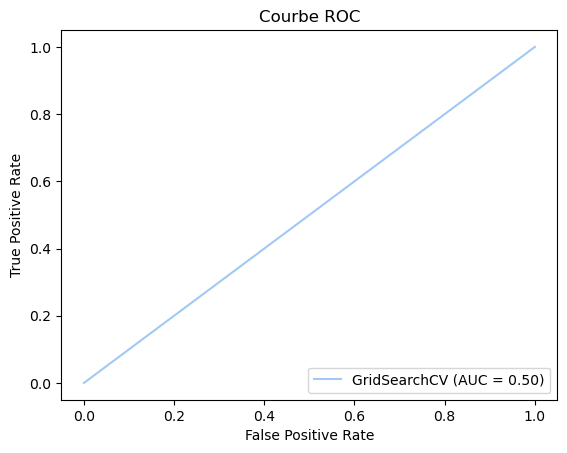

Run Dummy Classifier - done in 479s


In [14]:
with timer("Run Dummy Classifier"):
    dummy_classifier(df,debug = debug,train_smote = False)

In [10]:
debug = False
num_rows = 10000 if debug else None
df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()
    
#Extraction training set/testing set

df_ytrain = df[df['TARGET'].notnull()]
df_ytrain[['TARGET']].to_csv('target.csv', index= False)   
df_ytrain.to_csv('train.csv', index= False)   

df_xtest = df[df['TARGET'].isnull()]
df_xtest.to_csv('xtest.csv', index= False)  

Train samples: 307511, test samples: 48744


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 18s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 21s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 11s
Installments payments df shape: (339587, 26)
Process installments payments - done in 28s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 14s


In [9]:
xtrain = pd.read_csv('xtrain.csv', nrows=10000)
#compression_opts = dict(method='xz',archive_name='xtrain.csv')
xtrain.to_csv('xtrain_.csv',index=False)

Starting Random Forest //to extract features// Train shape: (10000, 799), test shape: (10000, 799)
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 10, 'n_estimators': 1000}
Meilleur score métier sur le jeu d'entraînement:
0.5657723745907648
Meilleur roc auc sur le jeu d'entraînement:
0.7281517615176152
Meilleur accuracy sur le jeu d'entraînement:
0.7198
Résultats de la validation croisée :
score métier = 0.566 (+/-0.043) roc auc = 0.728 (+/-0.036) accuracy = 0.720 (+/-0.068) for {'max_depth': 10, 'n_estimators': 1000}
Starting Regression Logistic Train shape: (307507, 799), test shape: (48744, 799)


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Meilleur score métier sur le jeu d'entraînement:
0.5532149145796048
Meilleur roc auc sur le jeu d'entraînement:
0.721251773525671
Meilleur accuracy sur le jeu d'entraînement:
0.7173722263175358
Seuil Retenu sur le jeu d'entraînement:
0.092


Registered model 'tracking-regression-logistic' already exists. Creating a new version of this model...
2024/04/25 20:25:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-regression-logistic, version 17


Résultats de la validation croisée :
score métier = 0.549 (+/-0.005) roc auc = 0.720 (+/-0.007) accuracy = 0.709 (+/-0.004) seuil = 0.090 (+/-0.000) for {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
score métier = 0.551 (+/-0.011) roc auc = 0.719 (+/-0.007) accuracy = 0.716 (+/-0.030) seuil = 0.092 (+/-0.008) for {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
score métier = 0.553 (+/-0.006) roc auc = 0.721 (+/-0.007) accuracy = 0.717 (+/-0.026) seuil = 0.092 (+/-0.008) for {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
score métier = 0.550 (+/-0.005) roc auc = 0.721 (+/-0.007) accuracy = 0.710 (+/-0.003) seuil = 0.090 (+/-0.000) for {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
score métier = 0.550 (+/-0.013) roc auc = 0.721 (+/-0.007) accuracy = 0.708 (+/-0.050) seuil = 0.090 (+/-0.013) for {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
score métier = 0.553 (+/-0.006) roc auc = 0.721 (+/-0.007) accuracy = 0.717 (+/-0.027) seuil = 0.092 (+/-0.008) for {'C': 10, 'penalty': 'l2', 'solver': 'saga

Created version '17' of model 'tracking-regression-logistic'.


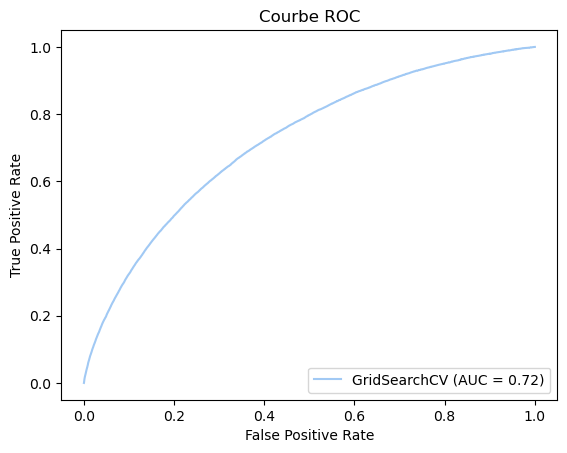

Run Reg Log - done in 1003s


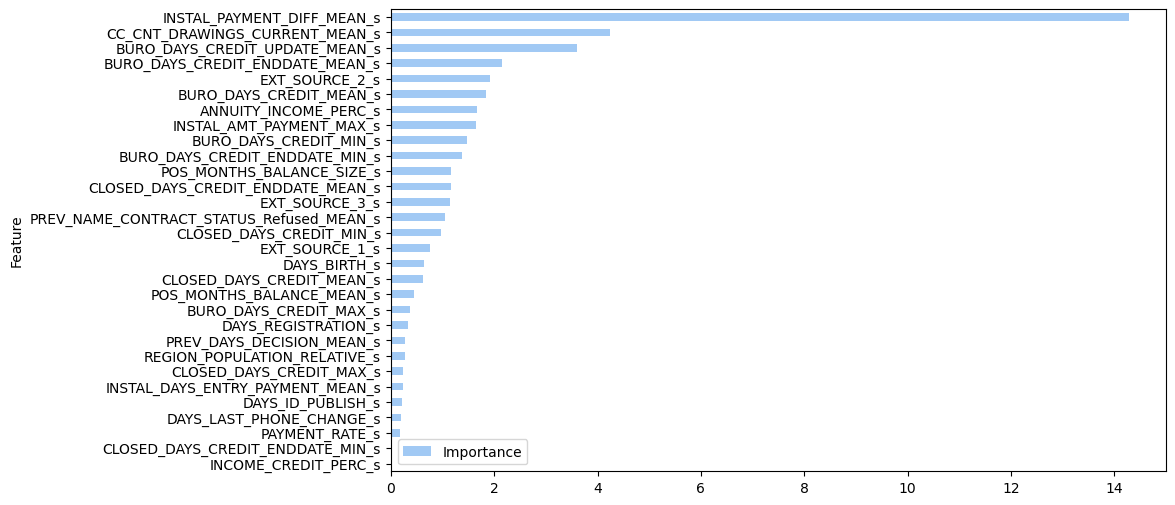

In [16]:
with timer("Run Reg Log"):
    reg_log(df,debug = debug,train_smote = False)

In [17]:
debug = False
num_rows = 10000 if debug else None
df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

Train samples: 307511, test samples: 48744


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 17s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 21s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 11s
Installments payments df shape: (339587, 26)
Process installments payments - done in 27s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 13s


Starting Random Forest //to extract features// Train shape: (10000, 799), test shape: (10000, 799)
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 10, 'n_estimators': 1000}
Meilleur score métier sur le jeu d'entraînement:
0.5812332144254354
Meilleur roc auc sur le jeu d'entraînement:
0.726756534662121
Meilleur accuracy sur le jeu d'entraînement:
0.7552999999999999
Résultats de la validation croisée :
score métier = 0.581 (+/-0.035) roc auc = 0.727 (+/-0.039) accuracy = 0.755 (+/-0.053) for {'max_depth': 10, 'n_estimators': 1000}
Starting Random Forest Train shape: (307507, 799), test shape: (48744, 799)
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 10, 'n_estimators': 300}
Meilleur score métier sur le jeu d'entraînement:
0.5615359758582148
Meilleur roc auc sur le jeu d'entraînement:
0.7359923538194986
Meilleur accuracy sur le jeu d'entraînement:
0.7138407278096471
Seuil Retenu sur le jeu d'entraînement:
0.092


Registered model 'tracking-random-forest' already exists. Creating a new version of this model...
2024/04/25 21:07:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-random-forest, version 58


Résultats de la validation croisée :
score métier = 0.558 (+/-0.004) roc auc = 0.735 (+/-0.006) accuracy = 0.705 (+/-0.004) seuil = 0.090 (+/-0.000) for {'max_depth': 10, 'n_estimators': 100}
score métier = 0.562 (+/-0.013) roc auc = 0.736 (+/-0.006) accuracy = 0.714 (+/-0.036) seuil = 0.092 (+/-0.008) for {'max_depth': 10, 'n_estimators': 300}


Created version '58' of model 'tracking-random-forest'.


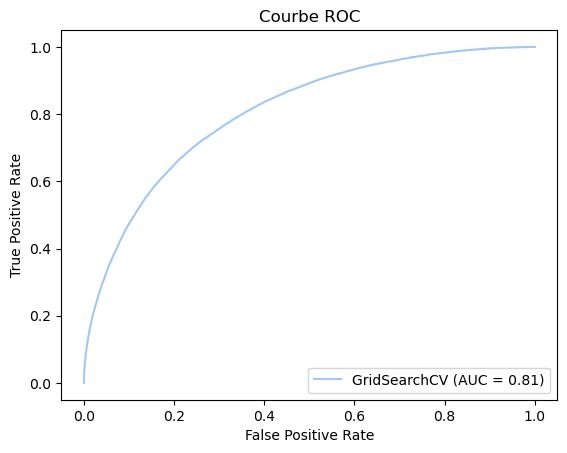

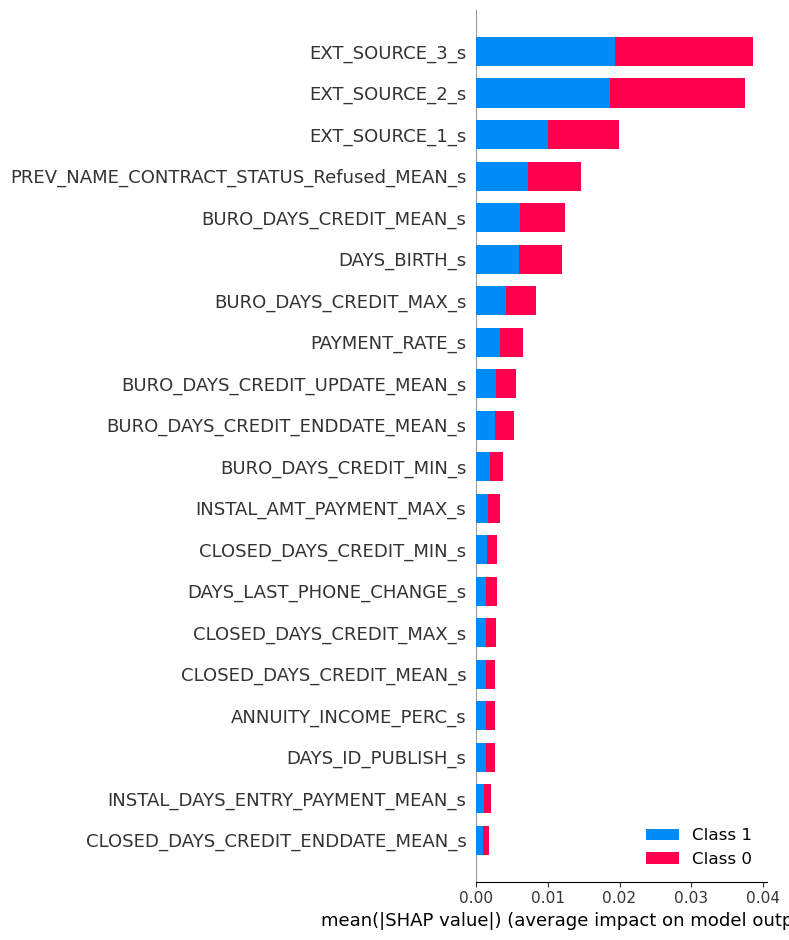

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


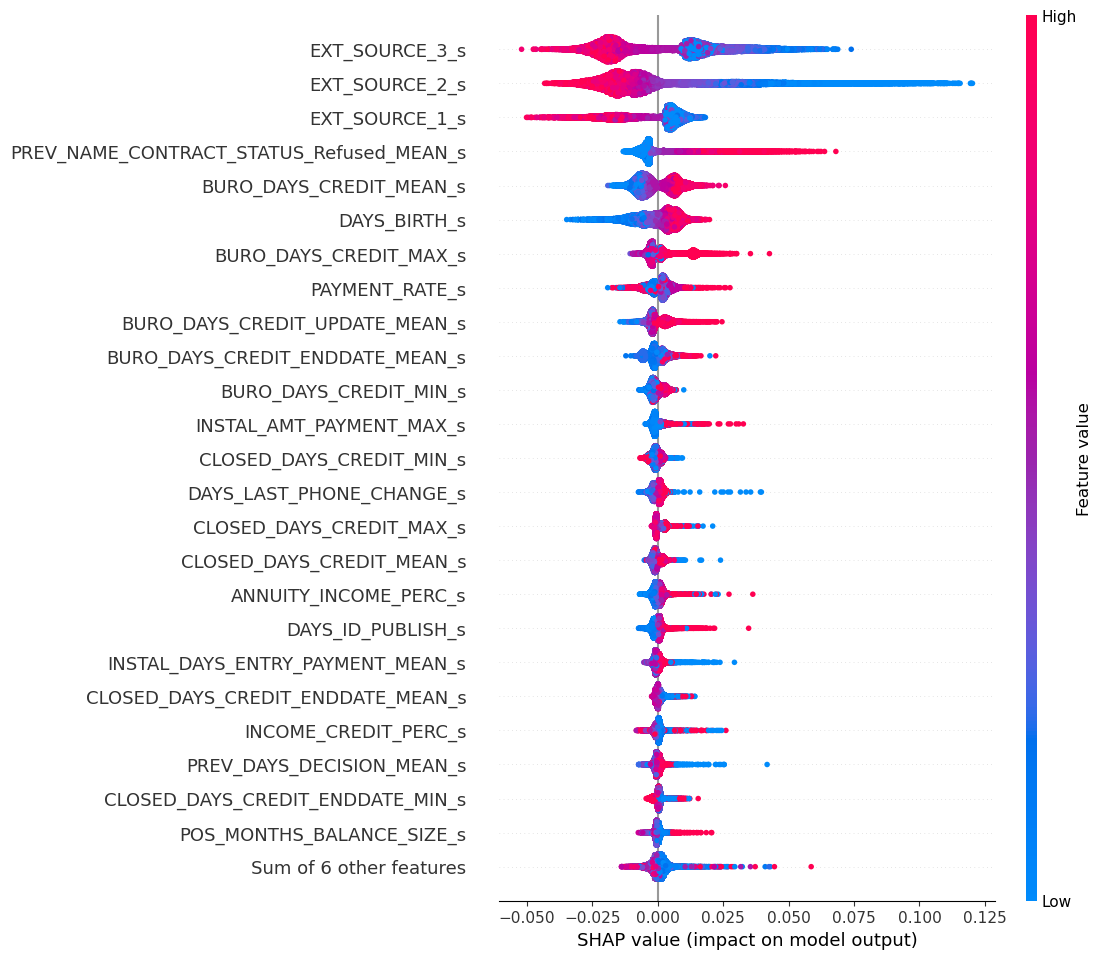

Run Random Forest - done in 8590s


In [18]:
with timer("Run Random Forest"):
    random_forest(df,debug = debug,train_smote = False)

In [19]:
debug = False
num_rows = 10000 if debug else None
df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

Train samples: 307511, test samples: 48744


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 18s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 21s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 11s
Installments payments df shape: (339587, 26)
Process installments payments - done in 27s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 13s


Starting Random Forest //to extract features// Train shape: (10000, 799), test shape: (10000, 799)
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 10, 'n_estimators': 1000}
Meilleur score métier sur le jeu d'entraînement:
0.5803256265139336
Meilleur roc auc sur le jeu d'entraînement:
0.7266019756971763
Meilleur accuracy sur le jeu d'entraînement:
0.7466
Résultats de la validation croisée :
score métier = 0.580 (+/-0.030) roc auc = 0.727 (+/-0.042) accuracy = 0.747 (+/-0.038) for {'max_depth': 10, 'n_estimators': 1000}
Starting XGBoost Train shape: (307507, 799), test shape: (48744, 799)
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'gamma': 1.5, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'nthread': 20, 'subsample': 0.6}
Meilleur score métier sur le jeu d'entraînement:
0.5871652882480003
Meilleur roc auc sur le jeu d'entraînement:
0.7649642543110009
Meilleur accuracy sur le jeu d'entraînement:
0.7394921087783584
Seuil Retenu sur le jeu

Registered model 'tracking-xgboost' already exists. Creating a new version of this model...
2024/04/25 23:15:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-xgboost, version 29


Résultats de la validation croisée :
score métier = 0.580 (+/-0.014) roc auc = 0.755 (+/-0.006) accuracy = 0.732 (+/-0.036) seuil = 0.094 (+/-0.010) for {'gamma': 1.5, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'nthread': 20, 'subsample': 0.6}
score métier = 0.587 (+/-0.010) roc auc = 0.765 (+/-0.005) accuracy = 0.739 (+/-0.038) seuil = 0.090 (+/-0.013) for {'gamma': 1.5, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'nthread': 20, 'subsample': 0.6}
score métier = 0.580 (+/-0.012) roc auc = 0.761 (+/-0.006) accuracy = 0.722 (+/-0.034) seuil = 0.086 (+/-0.010) for {'gamma': 1.5, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'nthread': 20, 'subsample': 0.6}
score métier = 0.579 (+/-0.007) roc auc = 0.759 (+/-0.007) accuracy = 0.727 (+/-0.029) seuil = 0.084 (+/-0.010) for {'gamma': 1.5, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'nthread': 20, 'subsample': 0.6}


Created version '29' of model 'tracking-xgboost'.


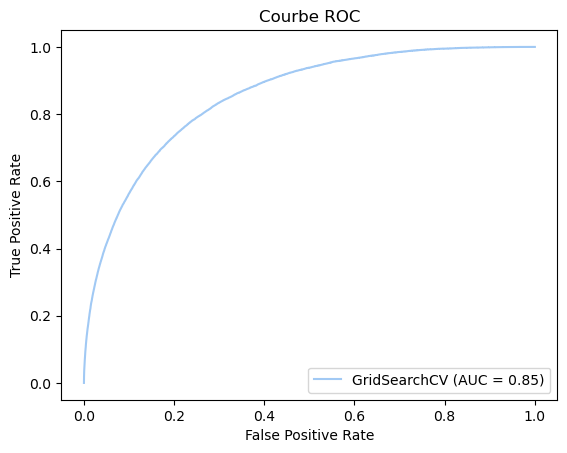

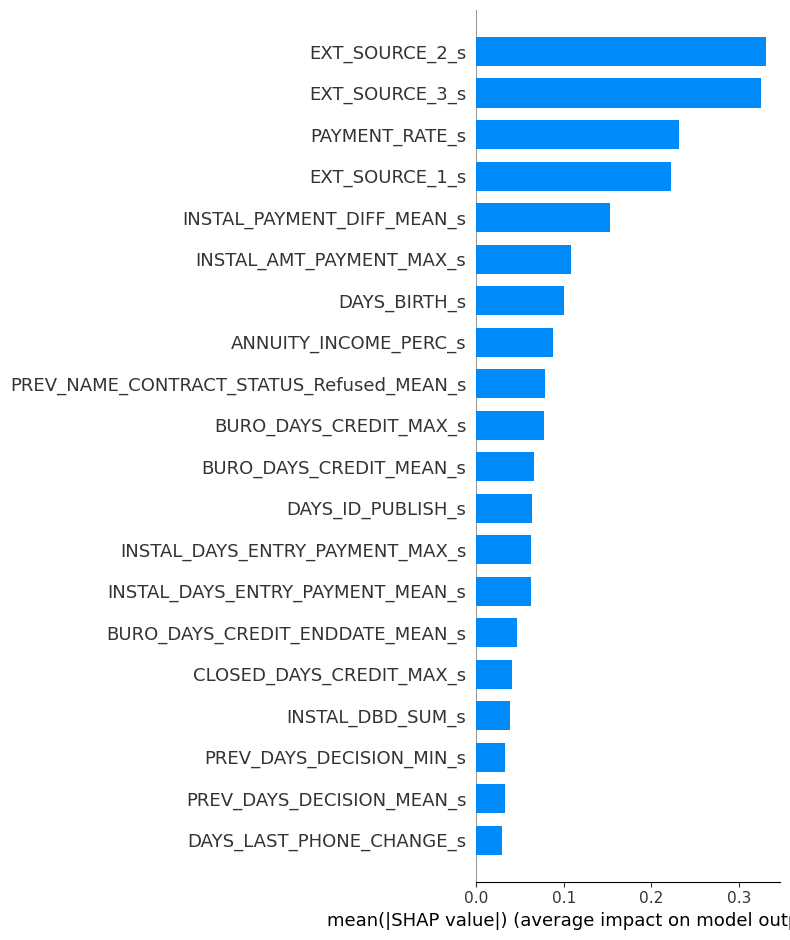

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


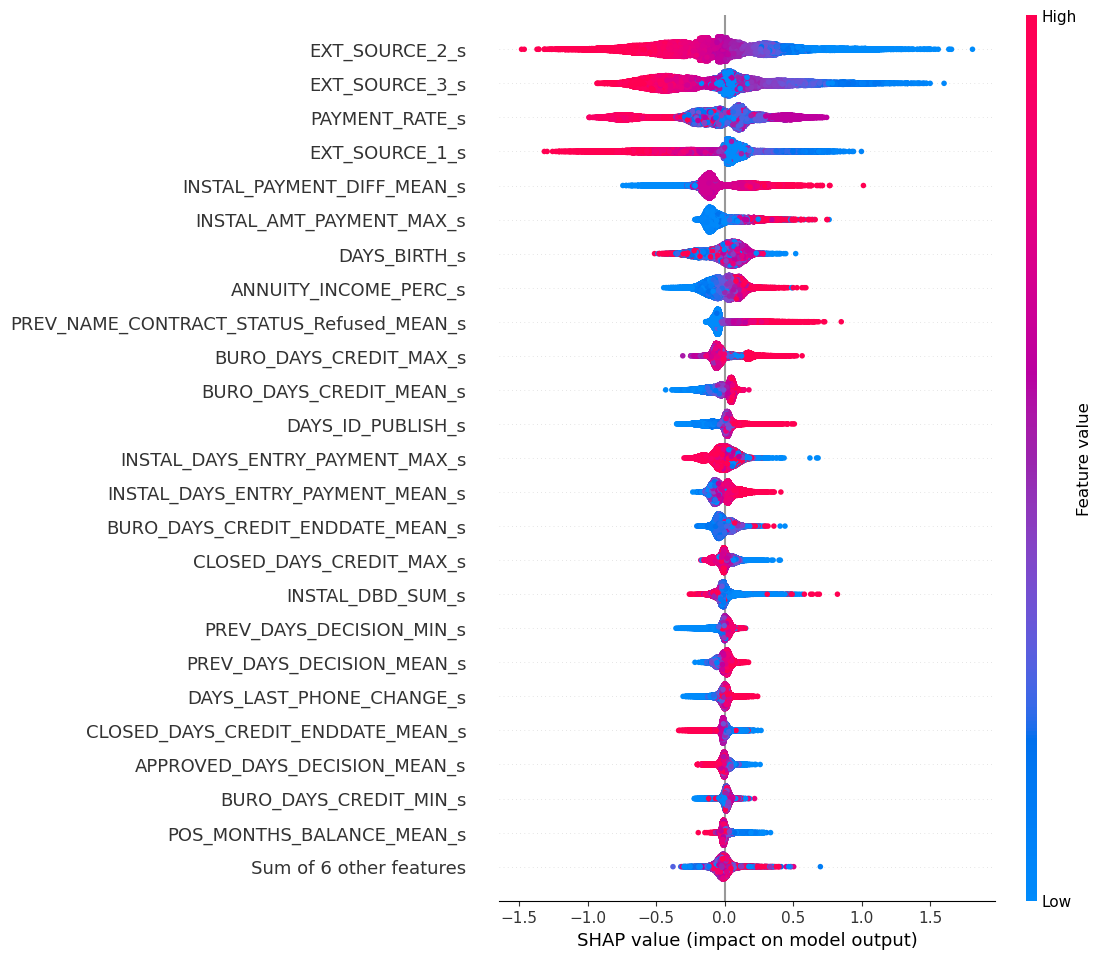

Run XGBoost - done in 1572s


In [20]:
with timer("Run XGBoost"):
    XGBoost(df,debug = debug)

## B. Lancement des modèles avec rééquilibrage SMOTE

In [21]:
debug = False
num_rows = 10000 if debug else None
df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

Train samples: 307511, test samples: 48744


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 18s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 21s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 11s
Installments payments df shape: (339587, 26)
Process installments payments - done in 27s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 13s


Starting Random Forest //to extract features// Train shape: (10000, 799), test shape: (10000, 799)
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 10, 'n_estimators': 1000}
Meilleur score métier sur le jeu d'entraînement:
0.5652003835640184
Meilleur roc auc sur le jeu d'entraînement:
0.7269887227904537
Meilleur accuracy sur le jeu d'entraînement:
0.7188000000000001
Résultats de la validation croisée :
score métier = 0.565 (+/-0.031) roc auc = 0.727 (+/-0.038) accuracy = 0.719 (+/-0.055) for {'max_depth': 10, 'n_estimators': 1000}
Starting Regression Logistic Train shape: (307507, 799), test shape: (48744, 799)


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'classification__C': 100, 'classification__penalty': 'l2', 'classification__solver': 'saga', 'sampling__k_neighbors': 3, 'sampling__sampling_strategy': 0.2}
Meilleur score métier sur le jeu d'entraînement:
0.5521802104189023
Meilleur roc auc sur le jeu d'entraînement:
0.7183213031693668
Meilleur accuracy sur le jeu d'entraînement:
0.7161495376503415
Seuil Retenu sur le jeu d'entraînement:
0.188


Registered model 'tracking-regression-logistic' already exists. Creating a new version of this model...
2024/04/26 00:31:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-regression-logistic, version 18
Created version '18' of model 'tracking-regression-logistic'.


Résultats de la validation croisée :
score métier = 0.549 (+/-0.009) roc auc = 0.718 (+/-0.007) accuracy = 0.708 (+/-0.021) seuil = 0.184 (+/-0.010) for {'classification__C': 0.1, 'classification__penalty': 'l1', 'classification__solver': 'saga', 'sampling__k_neighbors': 3, 'sampling__sampling_strategy': 0.2}
score métier = 0.548 (+/-0.018) roc auc = 0.718 (+/-0.007) accuracy = 0.706 (+/-0.045) seuil = 0.282 (+/-0.027) for {'classification__C': 0.1, 'classification__penalty': 'l1', 'classification__solver': 'saga', 'sampling__k_neighbors': 3, 'sampling__sampling_strategy': 0.35}
score métier = 0.549 (+/-0.013) roc auc = 0.718 (+/-0.007) accuracy = 0.709 (+/-0.035) seuil = 0.362 (+/-0.023) for {'classification__C': 0.1, 'classification__penalty': 'l1', 'classification__solver': 'saga', 'sampling__k_neighbors': 3, 'sampling__sampling_strategy': 0.5}
score métier = 0.547 (+/-0.015) roc auc = 0.718 (+/-0.007) accuracy = 0.703 (+/-0.035) seuil = 0.182 (+/-0.015) for {'classification__C': 0.

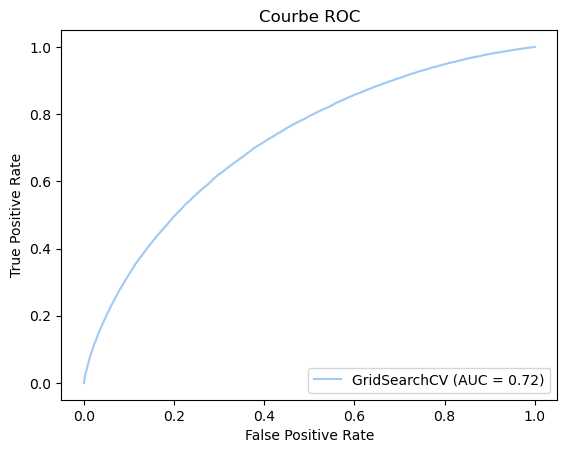

Run Reg Log - done in 4301s


In [22]:
with timer("Run Reg Log"):
    reg_log(df,debug = debug,train_smote = True)

In [23]:
debug = False
num_rows = 10000 if debug else None
df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

Train samples: 307511, test samples: 48744


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 18s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 21s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 11s
Installments payments df shape: (339587, 26)
Process installments payments - done in 28s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 13s


Starting Random Forest //to extract features// Train shape: (10000, 799), test shape: (10000, 799)
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 10, 'n_estimators': 1000}
Meilleur score métier sur le jeu d'entraînement:
0.5752602466760525
Meilleur roc auc sur le jeu d'entraînement:
0.7283832502841158
Meilleur accuracy sur le jeu d'entraînement:
0.7359000000000001
Résultats de la validation croisée :
score métier = 0.575 (+/-0.033) roc auc = 0.728 (+/-0.039) accuracy = 0.736 (+/-0.017) for {'max_depth': 10, 'n_estimators': 1000}
Starting Random Forest Train shape: (307507, 799), test shape: (48744, 799)
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'classification__max_depth': 10, 'classification__n_estimators': 300, 'sampling__k_neighbors': 3, 'sampling__sampling_strategy': 0.2}
Meilleur score métier sur le jeu d'entraînement:
0.5608097192174668
Meilleur roc auc sur le jeu d'entraînement:
0.7355331924486018
Meilleur accuracy sur le jeu d'entraînemen

Registered model 'tracking-random-forest' already exists. Creating a new version of this model...
2024/04/26 04:36:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-random-forest, version 59


Résultats de la validation croisée :
score métier = 0.556 (+/-0.017) roc auc = 0.734 (+/-0.005) accuracy = 0.698 (+/-0.052) seuil = 0.174 (+/-0.020) for {'classification__max_depth': 10, 'classification__n_estimators': 100, 'sampling__k_neighbors': 3, 'sampling__sampling_strategy': 0.2}
score métier = 0.552 (+/-0.015) roc auc = 0.728 (+/-0.008) accuracy = 0.699 (+/-0.026) seuil = 0.260 (+/-0.013) for {'classification__max_depth': 10, 'classification__n_estimators': 100, 'sampling__k_neighbors': 3, 'sampling__sampling_strategy': 0.35}
score métier = 0.545 (+/-0.014) roc auc = 0.724 (+/-0.007) accuracy = 0.689 (+/-0.029) seuil = 0.320 (+/-0.018) for {'classification__max_depth': 10, 'classification__n_estimators': 100, 'sampling__k_neighbors': 3, 'sampling__sampling_strategy': 0.5}
score métier = 0.559 (+/-0.011) roc auc = 0.735 (+/-0.003) accuracy = 0.709 (+/-0.035) seuil = 0.178 (+/-0.015) for {'classification__max_depth': 10, 'classification__n_estimators': 100, 'sampling__k_neighbors

Created version '59' of model 'tracking-random-forest'.


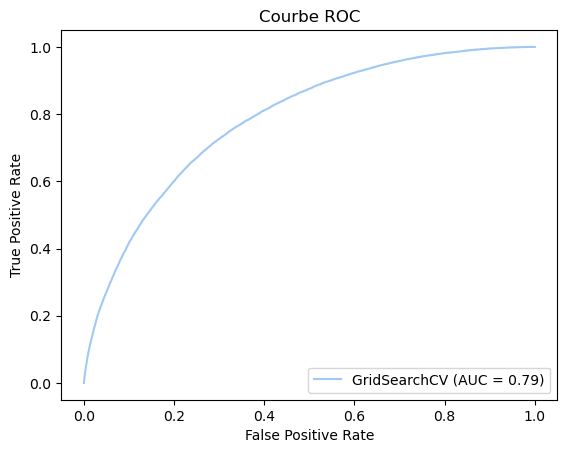

Run Random Forest avec SMOTE - done in 14627s


In [24]:
with timer("Run Random Forest avec SMOTE"):
    random_forest(df,debug = debug , train_smote = True)

In [25]:
debug = False
num_rows = 10000 if debug else None
df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

Train samples: 307511, test samples: 48744


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 18s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 21s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 11s
Installments payments df shape: (339587, 26)
Process installments payments - done in 27s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 14s


Starting Random Forest //to extract features// Train shape: (10000, 799), test shape: (10000, 799)
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 10, 'n_estimators': 1000}
Meilleur score métier sur le jeu d'entraînement:
0.5627400171435435
Meilleur roc auc sur le jeu d'entraînement:
0.7257746306495323
Meilleur accuracy sur le jeu d'entraînement:
0.7168000000000001
Résultats de la validation croisée :
score métier = 0.563 (+/-0.031) roc auc = 0.726 (+/-0.041) accuracy = 0.717 (+/-0.084) for {'max_depth': 10, 'n_estimators': 1000}
Starting XGBoost Train shape: (307507, 799), test shape: (48744, 799)
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'classification__gamma': 1.5, 'classification__learning_rate': 0.05, 'classification__max_depth': 7, 'classification__n_estimators': 100, 'classification__nthread': 20, 'classification__subsample': 0.6, 'sampling__k_neighbors': 5, 'sampling__sampling_strategy': 0.2}
Meilleur score métier sur le jeu d'entraînemen

Registered model 'tracking-xgboost' already exists. Creating a new version of this model...
2024/04/26 06:44:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-xgboost, version 30


Résultats de la validation croisée :
score métier = 0.570 (+/-0.016) roc auc = 0.745 (+/-0.007) accuracy = 0.726 (+/-0.037) seuil = 0.170 (+/-0.018) for {'classification__gamma': 1.5, 'classification__learning_rate': 0.05, 'classification__max_depth': 7, 'classification__n_estimators': 100, 'classification__nthread': 20, 'classification__subsample': 0.6, 'sampling__k_neighbors': 3, 'sampling__sampling_strategy': 0.2}
score métier = 0.563 (+/-0.018) roc auc = 0.734 (+/-0.008) accuracy = 0.724 (+/-0.042) seuil = 0.240 (+/-0.028) for {'classification__gamma': 1.5, 'classification__learning_rate': 0.05, 'classification__max_depth': 7, 'classification__n_estimators': 100, 'classification__nthread': 20, 'classification__subsample': 0.6, 'sampling__k_neighbors': 3, 'sampling__sampling_strategy': 0.35}
score métier = 0.552 (+/-0.013) roc auc = 0.729 (+/-0.007) accuracy = 0.704 (+/-0.027) seuil = 0.280 (+/-0.018) for {'classification__gamma': 1.5, 'classification__learning_rate': 0.05, 'classif

Created version '30' of model 'tracking-xgboost'.


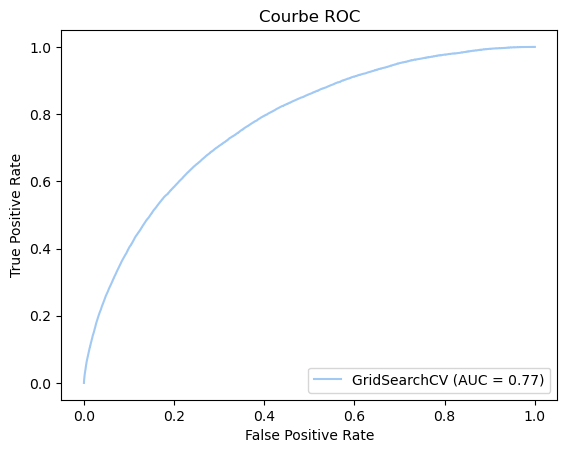

Run XGBoost avec SMOTE - done in 7596s


In [26]:
with timer("Run XGBoost avec SMOTE"):
    XGBoost(df, debug = debug , train_smote = True)

## C. Affinage des hyperparamètres sur le modèle choisi XGBoost

### 1/ Ajustement avec un plus grand nombre d'hyperparamètres et avec un RandomizedSearchCV:
* 'min_child_weight': [1,3,5],
* 'gamma': [1,1.5],
* 'subsample': [0.6,0.7,0.8,0.9],
* 'colsample_bytree': [0.6,0.7,0.8,0.9],
* 'max_depth': [5,7,9],
* 'learning_rate': [0.075,0.05],
* 'n_estimators': [300,500,1000]

### 2/ Ajout du nombres features en passant de 30 à 120 les plus importantes

In [30]:
def XGBoost_affine(df,debug = False):
    #Set our tracking server uri for logging
    mlflow.set_tracking_uri("http://localhost:5000")
    
    df, feats = extract_feature_importance_random_forest(df,120)

    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting XGBoost affiné Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    gc.collect()
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])

    data = df[feats] 
    xtrain = train_df[feats] 
    ytrain = train_df['TARGET']
                       
                
    # Choisir un score à optimiser, ici le
    scoring = {"Score_Metier":mon_score_metier,"AUC": "roc_auc", "Accuracy":accuracy_optimise,"Seuil":seuil_optimise}
 

    param_grid = {'nthread':[30],
        'min_child_weight': [1,3,5],
        'gamma': [1,1.5],
        'subsample': [0.6,0.7,0.8,0.9],
        'colsample_bytree': [0.6,0.7,0.8,0.9],
        'max_depth': [5,7,9],
        'learning_rate': [0.075,0.05],
        'n_estimators': [300,500,1000],
        'objective' : ['binary:logistic'],       
        }
    
    # Créer un XGBoost Classifier avec recherche d'hyperparamètre par validation croisée
    clf = model_selection.RandomizedSearchCV(
            xgb.XGBClassifier(), # Gradiant
            param_grid,     # hyperparamètres à tester
            cv=5,           # nombre de folds de validation croisée
            scoring=scoring,   # score à optimiser : score métier et scores à monitorer : accuracy/roc_auc 
            refit="Score_Metier",
            return_train_score=False,
            n_iter = 20
        )

    # Optimiser ce modèle sur le jeu d'entraînement
    start = time.time()
    clf.fit(xtrain, ytrain)
    tps_exec=(time.time() - start)

    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(clf.best_params_)


    print("Meilleur score métier sur le jeu d'entraînement:")
    print(clf.best_score_)

    print("Meilleur roc auc sur le jeu d'entraînement:")
    print(clf.cv_results_['mean_test_AUC'][clf.best_index_])
    
    print("Meilleur accuracy sur le jeu d'entraînement:")
    print(clf.cv_results_['mean_test_Accuracy'][clf.best_index_])

    print("Seuil Retenu sur le jeu d'entraînement:")
    print(clf.cv_results_['mean_test_Seuil'][clf.best_index_])
    
    #Tracking MLFLOW
    
    mlflow.set_experiment("Tracking Model Home Credit")
    
    with mlflow.start_run():
        # Log the hyperparameters
        mlflow.log_params(clf.best_params_)
    
        # Log du score métier 
        mlflow.log_metric("score métier", clf.best_score_)
        mlflow.log_metric("roc_auc", clf.cv_results_['mean_test_AUC'][clf.best_index_])
        mlflow.log_metric("accuracy", clf.cv_results_['mean_test_Accuracy'][clf.best_index_])
        mlflow.log_metric("seuil", clf.cv_results_['mean_test_Seuil'][clf.best_index_])        
        mlflow.log_metric("temps entraînement en sec",tps_exec)                     

        # Set a tag that we can use to remind ourselves what this run was for

        mlflow.set_tag("Training Info", "Model XGBoost Optimisé avec Cross Validation sans rééquilibrage SMOT") 

        # Infer the model signature
        signature = infer_signature(xtrain, clf.predict_proba(xtrain))
    
        # Log the model
        model_info = mlflow.sklearn.log_model(
            sk_model=clf,
            artifact_path="HOME_CREDIT",
            signature=signature,
            input_example=xtrain,
            registered_model_name="tracking-xgboost",
        )               
                   
        mlflow.sklearn.save_model(clf, 'mlflow_model', signature=signature)       
        
        # Afficher les performances correspondantes
        print("Résultats de la validation croisée :")
        for mean_Score_Metier,std_Score_Metier,mean_roc_auc, std_roc_auc,mean_Accuracy,std_Accuracy,mean_Seuil,std_Seuil,params in zip(
                clf.cv_results_['mean_test_Score_Metier'], # score métier moyen
                clf.cv_results_['std_test_Score_Metier'],  # écart-type du score métier
                clf.cv_results_['mean_test_AUC'], # roc auc moyen
                clf.cv_results_['std_test_AUC'],  # écart-type du roc auc
                clf.cv_results_['mean_test_Accuracy'], # Accuracy moyen
                clf.cv_results_['std_test_Accuracy'],  # écart-type Accuracy
                clf.cv_results_['mean_test_Seuil'], # Seuil moyen
                clf.cv_results_['std_test_Seuil'],  # écart-type Seuil
                clf.cv_results_['params']           # valeur de l'hyperparamètre
            ):

            print("{} = {:.3f} (+/-{:.03f}) {} = {:.3f} (+/-{:.03f}) {} = {:.3f} (+/-{:.03f}) {} = {:.3f} (+/-{:.03f}) for {}".format(
                "score métier",
                mean_Score_Metier,
                std_Score_Metier*2,
                 "roc auc",
                mean_roc_auc,
                std_roc_auc*2,
                "accuracy",
                mean_Accuracy,
                std_Accuracy*2,
                "seuil",
                mean_Seuil,
                std_Seuil*2,
                params
            ) )

        #loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)
        loaded_model = mlflow.sklearn.load_model(model_info.model_uri)

        xtest = test_df[feats]

        #y_pred = clf.predict_proba(xtest)
        start = time.time()                     
        y_pred = loaded_model.predict_proba(xtest)[:,1]                   
        tps_exec=(time.time() - start)
                             
        mlflow.log_metric("temps inférence en sec",tps_exec)      
        
        #Extraction des données training et testing et des résultats
        if not debug:
            test_df['TARGET'] = y_pred
            test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_file_name.csv', index= False)
            test_df[feats].to_csv('xtest_norm.csv', index= False)
            xtrain.to_csv('xtrain.csv', index= False)
            
        # Courbe ROC
        display = RocCurveDisplay.from_estimator(clf, xtrain, ytrain)
        _ = display.ax_.set(xlabel='False Positive Rate',ylabel='True Positive Rate',title='Courbe ROC',)
        plt.savefig('Courbe-ROC.png',dpi=150)
        mlflow.log_artifact("Courbe-ROC.png")
        plt.show()

        model = clf.best_estimator_
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(xtest)

        shap.summary_plot(shap_values, xtest, plot_type="bar")

        shap_values = explainer(xtest) 
        shap.plots.beeswarm(shap_values, max_display=25)    

In [31]:
debug = False
num_rows = 10000 if debug else None
df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

Train samples: 307511, test samples: 48744


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 18s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 21s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 11s
Installments payments df shape: (339587, 26)
Process installments payments - done in 29s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 14s


Starting Random Forest //to extract features// Train shape: (10000, 799), test shape: (10000, 799)
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 10, 'n_estimators': 1000}
Meilleur score métier sur le jeu d'entraînement:
0.5747313088254642
Meilleur roc auc sur le jeu d'entraînement:
0.729846315237346
Meilleur accuracy sur le jeu d'entraînement:
0.733
Résultats de la validation croisée :
score métier = 0.575 (+/-0.043) roc auc = 0.730 (+/-0.039) accuracy = 0.733 (+/-0.089) for {'max_depth': 10, 'n_estimators': 1000}
Starting XGBoost affiné Train shape: (307507, 799), test shape: (48744, 799)
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'subsample': 0.7, 'objective': 'binary:logistic', 'nthread': 30, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.075, 'gamma': 1, 'colsample_bytree': 0.8}
Meilleur score métier sur le jeu d'entraînement:
0.6014012955103137
Meilleur roc auc sur le jeu d'entraînement:
0.7788439584944327
Mei

Registered model 'tracking-xgboost' already exists. Creating a new version of this model...
2024/04/26 22:34:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-xgboost, version 32
Created version '32' of model 'tracking-xgboost'.


Résultats de la validation croisée :
score métier = 0.597 (+/-0.013) roc auc = 0.782 (+/-0.005) accuracy = 0.735 (+/-0.032) seuil = 0.084 (+/-0.010) for {'subsample': 0.9, 'objective': 'binary:logistic', 'nthread': 30, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 1.5, 'colsample_bytree': 0.6}
score métier = 0.593 (+/-0.008) roc auc = 0.778 (+/-0.004) accuracy = 0.732 (+/-0.024) seuil = 0.082 (+/-0.008) for {'subsample': 0.6, 'objective': 'binary:logistic', 'nthread': 30, 'n_estimators': 1000, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.075, 'gamma': 1.5, 'colsample_bytree': 0.9}
score métier = 0.586 (+/-0.004) roc auc = 0.776 (+/-0.004) accuracy = 0.717 (+/-0.003) seuil = 0.070 (+/-0.000) for {'subsample': 0.6, 'objective': 'binary:logistic', 'nthread': 30, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.8}
score métier = 0.593 (+/-0.022) roc auc = 0.780 (+/

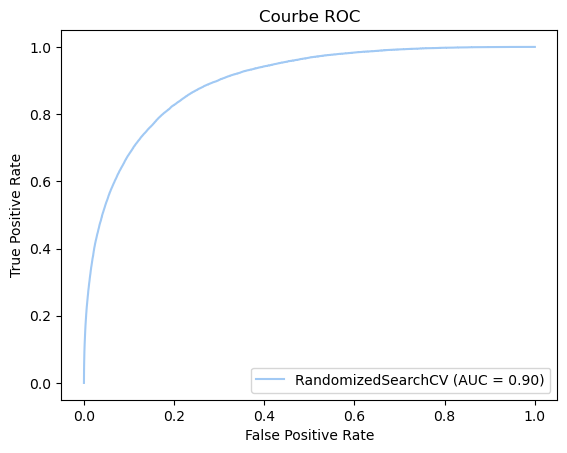

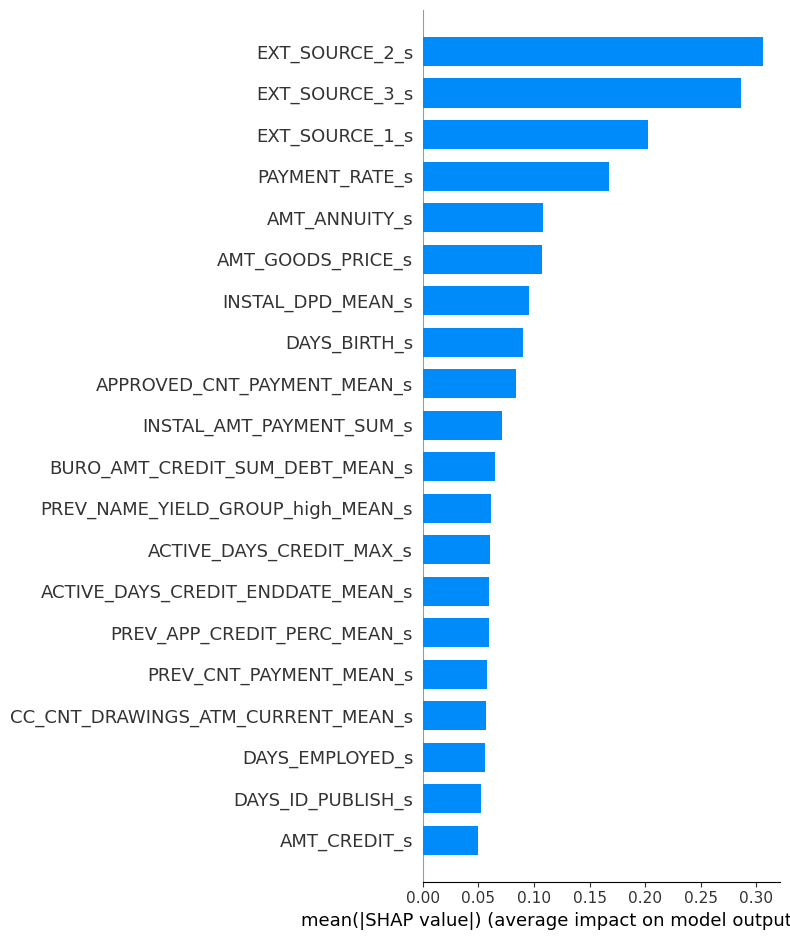

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


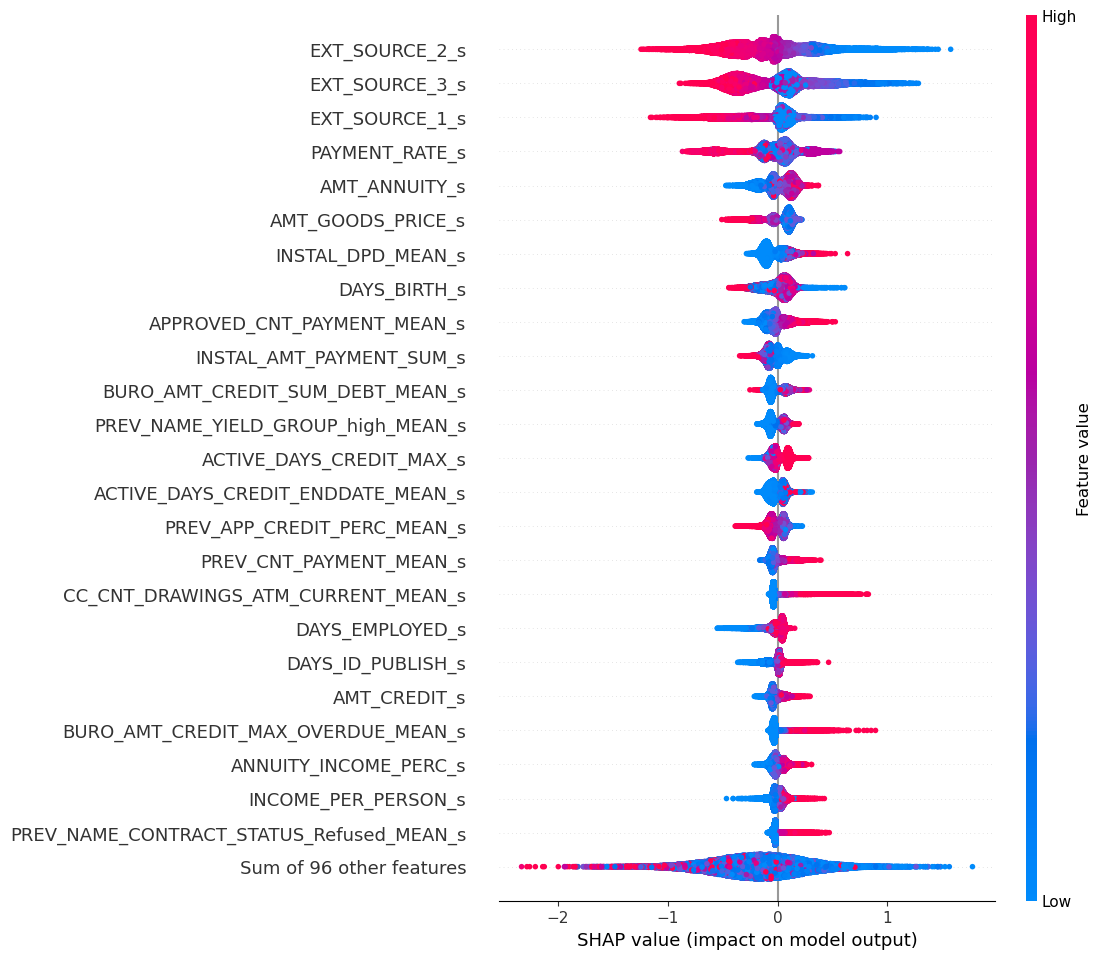

Run XGBoost optimisé - done in 30995s


In [32]:
with timer("Run XGBoost optimisé"):
    XGBoost_affine(df, debug = debug)

# IV. Data Drift entre les données d'Apprentissage / Test

In [33]:
debug = False
num_rows = 10000 if debug else None
df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

Train samples: 307511, test samples: 48744


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 18s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 22s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 11s
Installments payments df shape: (339587, 26)
Process installments payments - done in 28s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 14s


In [34]:
df, feats = extract_feature_importance_random_forest(df,30)
    
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

Starting Random Forest //to extract features// Train shape: (10000, 799), test shape: (10000, 799)
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 10, 'n_estimators': 1000}
Meilleur score métier sur le jeu d'entraînement:
0.5791517101668646
Meilleur roc auc sur le jeu d'entraînement:
0.7296665792464376
Meilleur accuracy sur le jeu d'entraînement:
0.7468999999999999
Résultats de la validation croisée :
score métier = 0.579 (+/-0.022) roc auc = 0.730 (+/-0.038) accuracy = 0.747 (+/-0.039) for {'max_depth': 10, 'n_estimators': 1000}


In [35]:
drift_report = Report(metrics=[DataDriftPreset(), TargetDriftPreset()])
 
drift_report.run(reference_data=train_df[feats], current_data=test_df[feats])
drift_report.save_html("data_drift.html")